In [1]:
from __future__ import annotations

In [2]:
import numpy as np
reactions = [
    ('k1', ['A', 'cat'], ['B'],),
    ('k-1', ['B'], ['A', 'cat'],),
    ('k2', ['B'], ['C', 'cat']),

    # labeled
    ('k1', ['A-d10', 'cat'], ['B-d10'],),
    ('k-1', ['B-d10'], ['A-d10', 'cat'],),
    ('k2', ['B-d10'], ['C-d10', 'cat'])
]

# look at as simple of a system as possible.
concentration_initial = {'A': 1, 'cat': 1 / 5}
concentration_labeled = {'A-d10': 1}
dilution_factor = 1
time_pre = np.linspace(0, 10, 50)
time_post = np.linspace(10, 90, 8 * 50)

C:\Users\mdingemans\AppData\Local\Temp\ipykernel_2748\1454955276.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


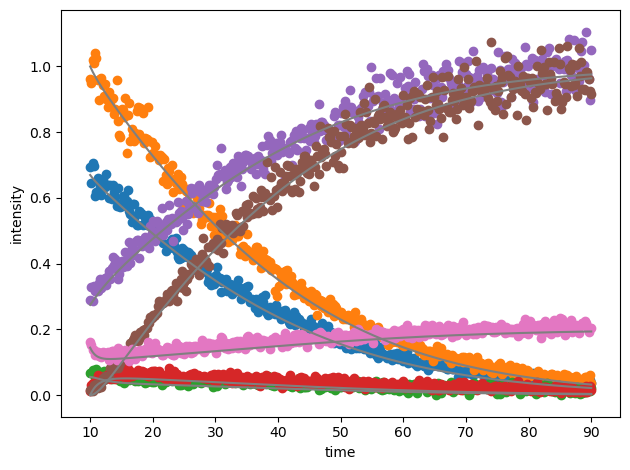

In [3]:
from delayed_reactant_labeling.predict import DRL
import pandas as pd

# create a "real" prediction.
rate_constants_real = {'k1': 0.3, 'k-1': 0.05, 'k2': 0.5}
drl_real = DRL(rate_constants=rate_constants_real, reactions=reactions)
real_data = drl_real.predict_concentration(
    t_eval_pre=time_pre,
    t_eval_post=time_post,
    dilution_factor=dilution_factor,
    initial_concentrations=concentration_initial,
    labeled_concentration=concentration_labeled)

# add noise
rng = np.random.default_rng(42)
fake_data = []
for col in real_data.columns[:-1]:  # the last column contains a time array, so skip that one.
    noise_dynamic = rng.normal(loc=1, scale=0.05, size=real_data[col].shape)  # fraction error
    noise_static = rng.normal(loc=0.015, scale=0.0075, size=real_data[col].shape)
    fake_col = real_data[col] * noise_dynamic + noise_static
    fake_col[fake_col < 1e-10] = 1e-10  # no negative intensity
    fake_data.append(fake_col)
fake_data.append(real_data['time'])
fake_data = pd.DataFrame(fake_data, index=real_data.columns).T

# visualize
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for col in fake_data.columns[:-1]:
    ax.plot(time_post, real_data[col], color="tab:gray")
    ax.scatter(time_post, fake_data[col], label=col)
ax.plot(np.nan, np.nan, color="tab:gray", label="real")
ax.set_xlabel("time")
ax.set_ylabel("intensity")
fig.tight_layout()
fig.show()

In [4]:
from delayed_reactant_labeling.predict import DRL
from delayed_reactant_labeling.optimize import RateConstantOptimizerTemplate

class RateConstantOptimizer(RateConstantOptimizerTemplate):
    @staticmethod
    def create_prediction(x: np.ndarray, x_description: list[str]) -> pd.DataFrame:
        rate_constants = pd.Series(x, x_description)
        # The rate constants can easily be manipulated here. For example,
        # rate_constants["k1"] = 0.42 would fixate that value.
        # Because Series are mutable, the changed version will be stored in the logs!

        drl = DRL(reactions=reactions, rate_constants=rate_constants)
        pred_labeled = drl.predict_concentration(
            t_eval_pre=time_pre,
            t_eval_post=time_post,
            initial_concentrations=concentration_initial,
            labeled_concentration=concentration_labeled,
            dilution_factor=dilution_factor,
            rtol=1e-8,
            atol=1e-8, )

        # The prediction can be altered here before its analyzed.
        return pred_labeled

    @staticmethod
    def calculate_curves(data: pd.DataFrame) -> dict[str, np.ndarray]:
        curves = {}
        for chemical in ['A', 'B', 'C']:
            chemical_sum = data[[chemical, f'{chemical}-d10']].sum(axis=1)
            curves[f'ratio_{chemical}'] = (data[chemical] / chemical_sum).to_numpy()
        return curves

In [5]:
def METRIC(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.average(np.abs(y_pred - y_true), axis=0)

In [16]:
from scipy.optimize import Bounds
description = ['k1', 'k-1', 'k2']
bounds = Bounds(np.array([1e-9, -0.042, 1e-9]), np.array([100, 0.042, 100]))  #lower bound, upper bound

RCO = RateConstantOptimizer(experimental=fake_data, metric=METRIC)
RCO.optimize(
    x0=np.array([1, 0.042, 1]),
    x_description=description,
    x_bounds=bounds,
    path='./optimization/', _overwrite_log=True)

progress = RCO.load_optimization_progress('./optimization/')

progress.best_X
# k1,   2.112804e-01
# k-1,  1.000000e-09
# k2,   6.424953e-01

  0%|          | 90/50000 [00:11<1:45:10,  7.91it/s]


k1     0.228992
k-1    0.042000
k2     0.617280
Name: 162, dtype: float64

In [15]:
RCO.optimize_multiple(
    path='./optimization_multiple/',
    n_runs=10,
    x_description=description,
    x_bounds=bounds,
    n_jobs=-2,
)

C:\Users\mdingemans\delayed_reactant_labeling\src\delayed_reactant_labeling\optimize.py:452: UserWarning: Cannot create a directory when that directory already exists. Appending results instead starting with seed 10
  warnings.warn("Cannot create a directory when that directory already exists. "


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.05338621139526367s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done   4 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done   5 out of  10 | elapsed:    1.5s remaining:    1.5s
[Parallel(n_jobs=-2)]: Done   6 out of  10 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=-2)]: Done   7 out of  10 | elapsed:    2.3s remaining:    0.9s
[Parallel(n_jobs=-2)]: Done   8 out of  10 | elapsed:    3.2s remaining:    0.7s
[Parallel(n_jobs=-2)]: Done  10 out of  10 | elapsed:    4.1s finished


In [13]:
import os

error = []
bestX = []
for file in os.listdir('./optimization_multiple/'):
    progress = RCO.load_optimization_progress(f'./optimization_multiple/{file}')
    error.append(progress.best_error)
    bestX.append(progress.best_X)

best_run = np.array(error).argmin()
print(error[best_run])
print(bestX[best_run])

0.1167975436
k1     0.228994
k-1    0.042000
k2     0.617304
Name: 181, dtype: float64
